# First construct dataframes for cryptocurrencies and price at the end of time intervals for minutes, hours and days.


In [1]:
import warnings
warnings.filterwarnings("ignore")

import cryptocompare
import pandas as pd
import numpy as np
%matplotlib inline
import datetime
import matplotlib.pyplot as plt

In [2]:
coins_list = ['BTC','ETH', 'SOL', 'ADA', 'DOT', 'XRP', 'ATOM', 'AVAX', 'LUNA', 'BNB', 'XTZ', 'FIL', 'LINK', 'FTT',
 'ALGO','LTC', 'DOGE', 'OMG', 'COTI', 'EOS', 'TRX', 'CELO', 'BCH', 'FTM', 'CELR', 'NEAR', 'MATIC', 'AXS', 'ETC',
 'IOST','XLM', 'HBAR', 'SRM', 'VET', 'THETA', 'CRV', 'EGLD', 'SUSHI', 'UNI', 'BTT', 'ONE', 'JST', 'ICP',
 'XMR','CVC','SHIB', 'WAVES', 'KAVA', 'GRT', 'OKB', 'REN', 'DASH', 'BSV', 'QTUM', 'KSM', 'CHZ', 'RUNE',
 'NEO', 'CAKE', 'DYDX', 'RSR', 'AAVE', 'ZEC', 'HT', 'MIOTA', 'COMP', 'SNX', 'ICX', 'ONT', 'FET', 'FLOW',
 'AR', 'SXP', '1INCH', 'ELF', 'SAND', 'MANA', 'MKR', 'WBTC', 'SLP', 'NANO', 'ZIL', 'ROSE', 'BAT', 'XEM', 'MLN',
 'HARD', 'QNT', 'ENJ', 'YFI', 'ZRX', 'HOT', 'SC', 'ONGAS', 'CTSI']

In [3]:
class Data:
    def __init__(self, coins, curr= 'USD'):
        self.coins = coins
        self.curr = curr
        
    def get_timeframe(self,lim,getter):
        df = pd.DataFrame()
        for coin in self.coins:
            result = getter(coin, currency = self.curr, limit=lim)
            #cryptocompare.get_historical_price_day(coin, currency = self.curr, limit=lim)
            name = f'close {coin}'
            series = pd.DataFrame.from_dict(result).iloc[:, [6]].squeeze()
            df[name] = series
        return df
    
    def get_days(self,lim = 60):
        return self.get_timeframe(lim = lim, getter = cryptocompare.get_historical_price_day)
    
    def get_days(self,lim = 168):
        return self.get_timeframe(lim = lim, getter = cryptocompare.get_historical_price_hour)
    
    def get_days(self,lim = 1440):
        return self.get_timeframe(lim = lim, getter = cryptocompare.get_historical_price_hour)

# Getting data

In [4]:
#gather the data
#do we need retrive a data?
EXTRACT = False

if EXTRACT:
    data = Data(coins_list)
    days = data.get_days()
    hours = data.get_hours()
    minutes = data.get_minutes()
    days.to_csv('data/days.csv')
    hours.to_csv('data/hours.csv')
    minutes.to_csv('data/minutes.csv')
else:
    days = pd.read_csv('data/days.csv', index_col=0) 
    minutes = pd.read_csv('data/minutes.csv', index_col=0) 
    hours = pd.read_csv('data/hours.csv', index_col=0) 

# Let's look at the data

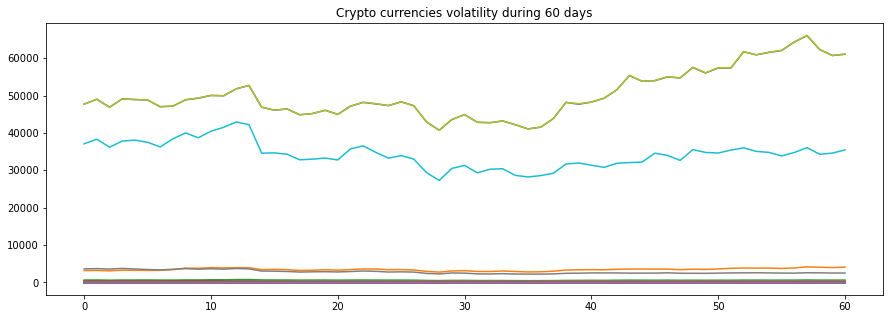

In [5]:
plt.figure(figsize=(15,5))
plt.plot(days)
plt.title('Crypto currencies volatility during 60 days')
plt.show()

# We can see that it is hard to understand anything from the plot ->  normalize the data using different scalers

In [23]:
from sklearn import preprocessing
scaler = preprocessing.MaxAbsScaler()
names = days.columns
d = scaler.fit_transform(days)
days_scaled = pd.DataFrame(d, columns=names)

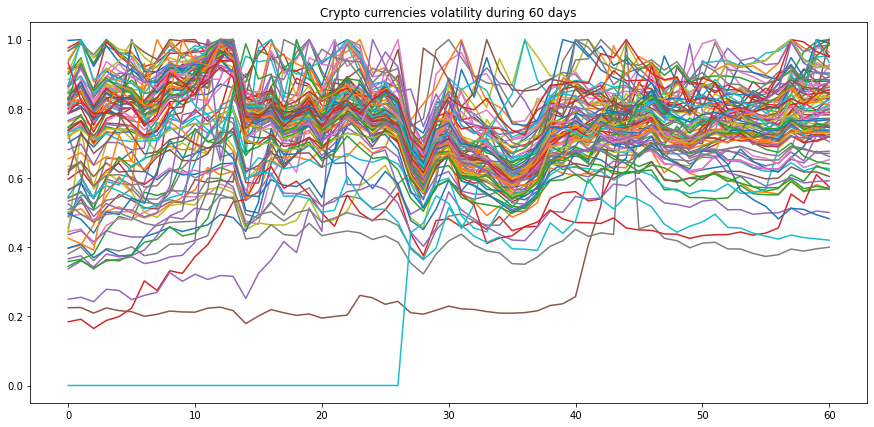

In [24]:
plt.figure(figsize=(15,7))
plt.plot(days_scaled)
plt.title('Crypto currencies volatility during 60 days')
plt.show()

## Tried MinMaxScaler() scaler

In [25]:
scaler = preprocessing.MinMaxScaler()
names = days.columns
d = scaler.fit_transform(days)
days_scaled = pd.DataFrame(d, columns=names)

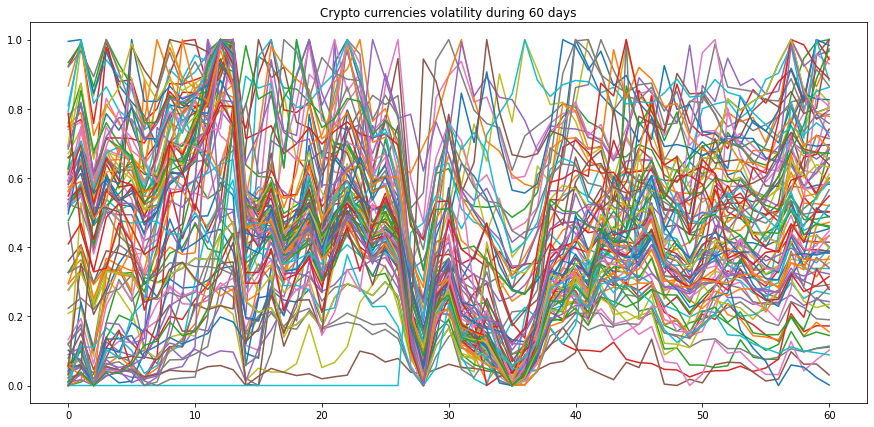

In [26]:
plt.figure(figsize=(15,7))
plt.plot(days_scaled)
plt.title('Crypto currencies volatility during 60 days')
plt.show()

# Look at data in separte plots.

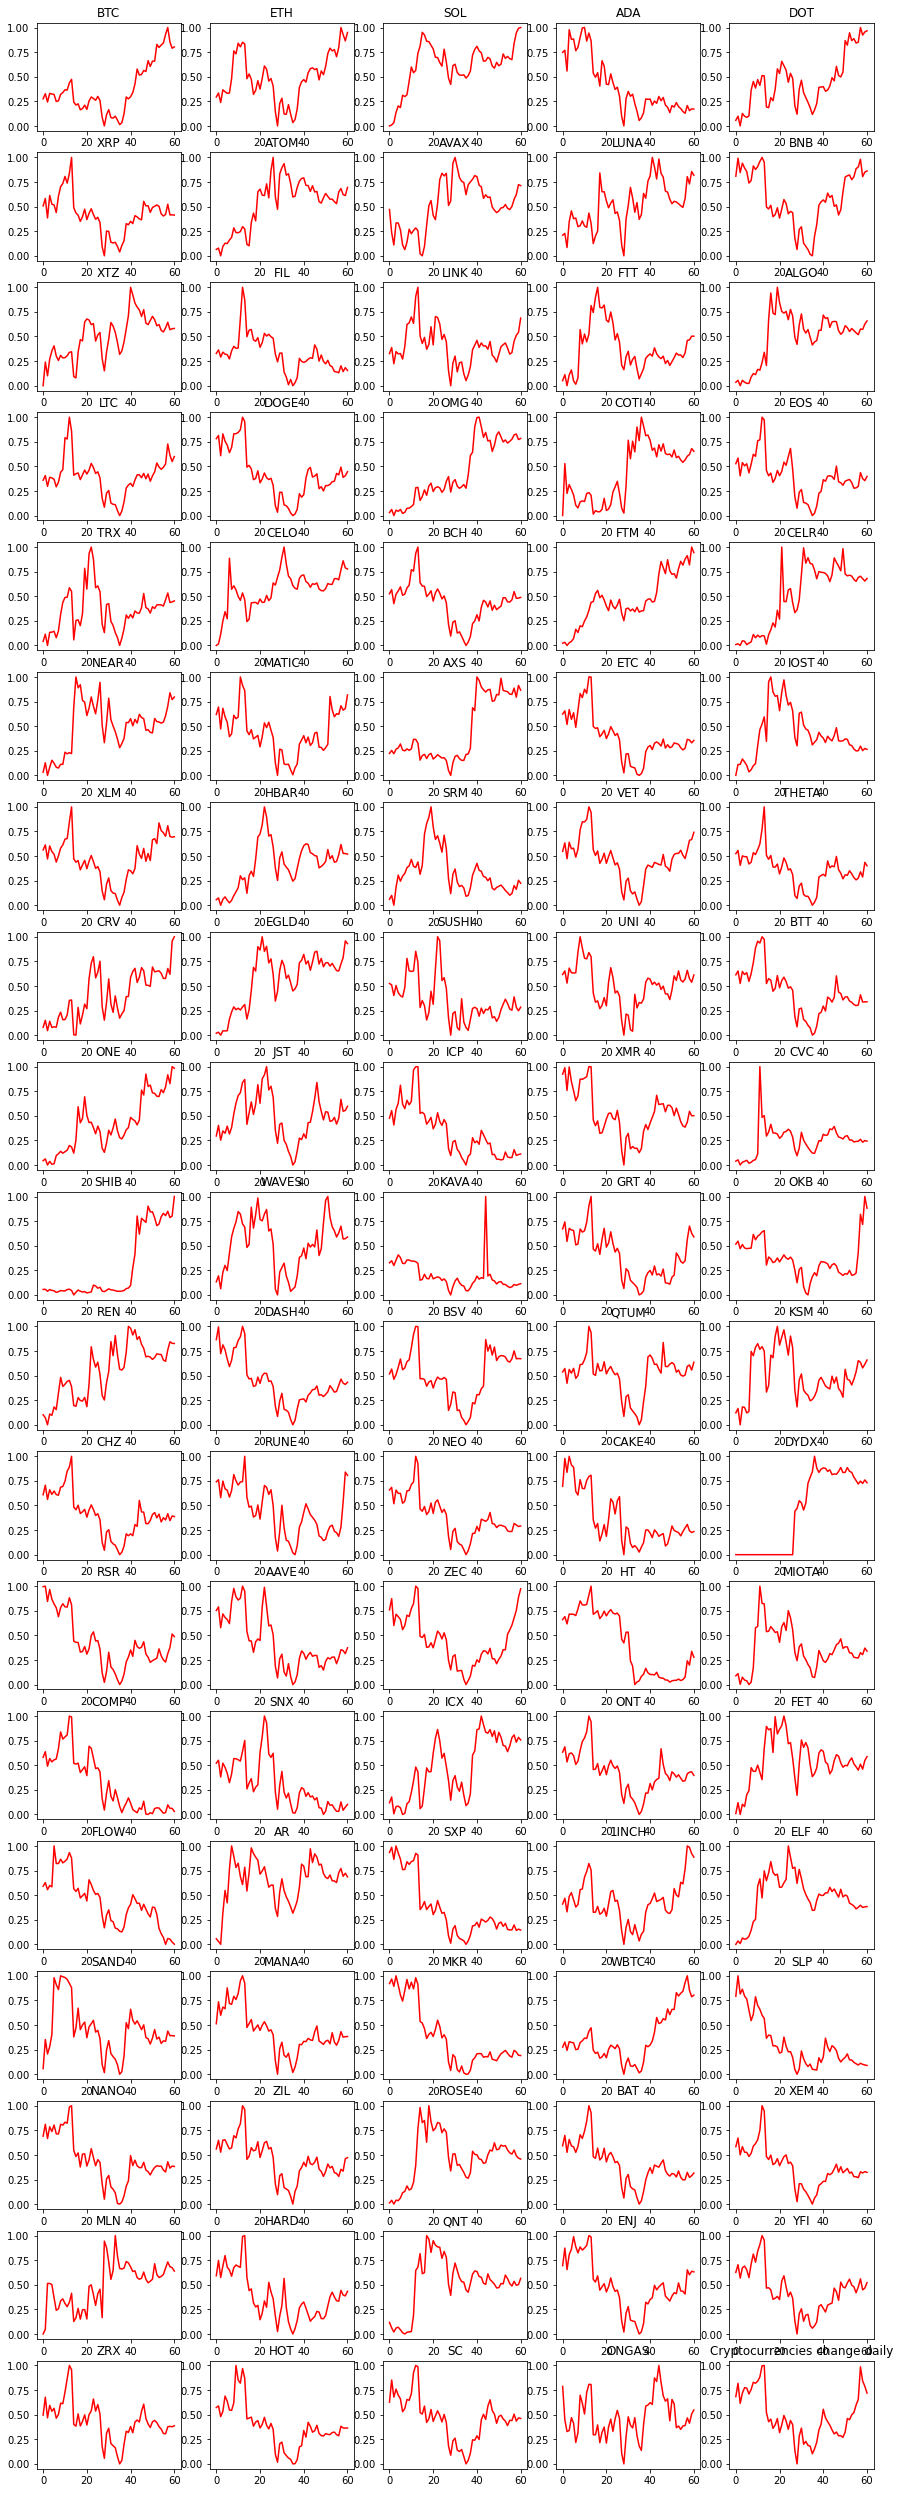

In [149]:
columns = 5
rows = 19
fig, ax_array = plt.subplots(rows, columns,figsize=(15,45),squeeze=False)
number = 0
for i,axrow in enumerate(ax_array):
    for j,axes in enumerate(axrow):
        axes.set_title(coins_list[number])
        axes.plot(days_scaled.iloc[:,number],'r-')
        number +=1
plt.title('Cryptocurrencies change daily')
plt.show()

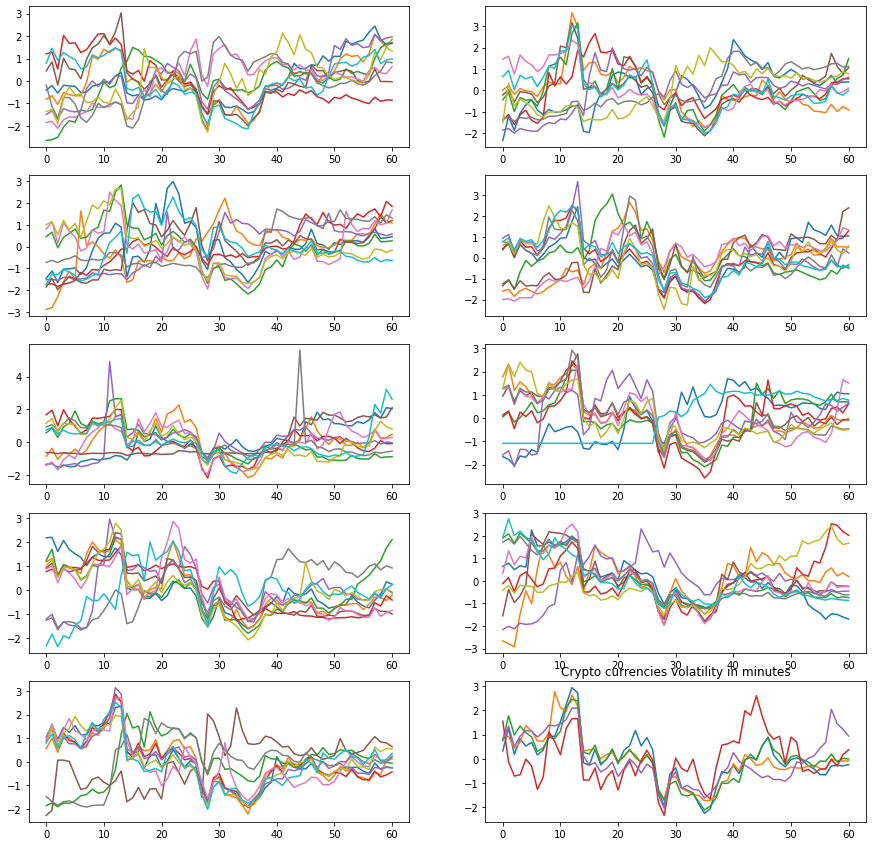

In [28]:
scaler = preprocessing.StandardScaler()
names = minutes.columns
d = scaler.fit_transform(days)
minutes_scaled = pd.DataFrame(d, columns=names)

columns = 2
rows = 5
fig, ax_array = plt.subplots(rows, columns,figsize=(15,15),squeeze=False)
number = 0
column = 10
for i,ax_row in enumerate(ax_array):
    for j,axes in enumerate(ax_row):
        axes.plot(minutes_scaled.iloc[:,number:column])
        number += 10
        column += 10
plt.title('Crypto currencies volatility in minutes')
plt.show()

# Clusterization with k-means 

Let's look how many clusters we could isolate

In [29]:
from tqdm.autonotebook import tqdm
from sklearn.cluster import KMeans
days_scaled_T = days_scaled.transpose()

def plot_distortions(k_range, data):
    distortions = []
    K = k_range
    for k in tqdm(K):
        kmeanModel = KMeans(n_clusters=k)
        kmeanModel.fit(data)
        distortions.append(kmeanModel.inertia_)

    plt.figure(figsize=(12,6))
    plt.plot(K, distortions, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Distortion')
    plt.title('Elbow Method')
    plt.show()

  0%|          | 0/9 [00:00<?, ?it/s]

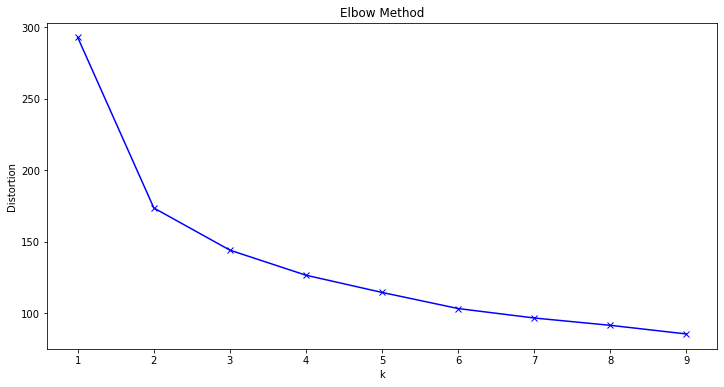

In [30]:
plot_distortions(range(1,10), days_scaled_T)

# From the plot it looks like there is 3 or 4 custers will work the best.

In [140]:
n_clusters = 6
kmeans = KMeans(n_clusters, random_state=0)

labels = kmeans.fit(days_scaled_T)

kmeans.labels_

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3], dtype=int32)

In [70]:
# save data for clusters
clusters = []
for n in range(n_clusters):
    name = str('cluster' + ' '+ str(n))
    clusters.append([s.split()[1] for s in list(days_scaled.columns[kmeans.labels_==n])])

# Plot according to cluster

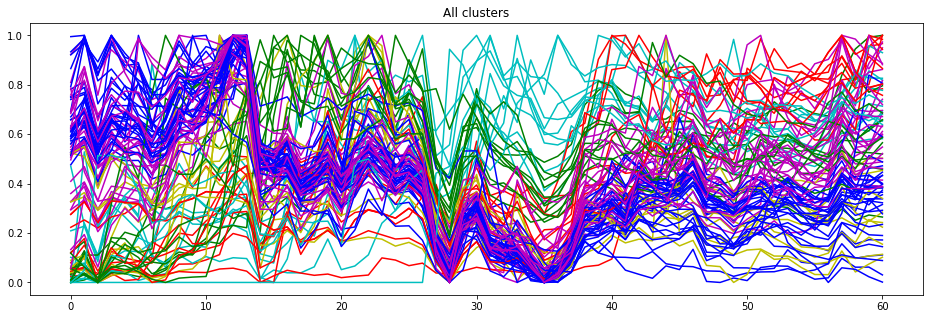

In [84]:
colors = ['b','g','r','c','m','y','k'] #length 7
plt.figure(figsize=(16, 5))

for item in range(len(kmeans.labels_)):
    for cluster in range(n_clusters):
        if kmeans.labels_[item] == cluster:
            plt.plot(days_scaled[days_scaled.columns[item]],color = colors[cluster])
plt.title("All clusters")
plt.show()

# Look at first cluster

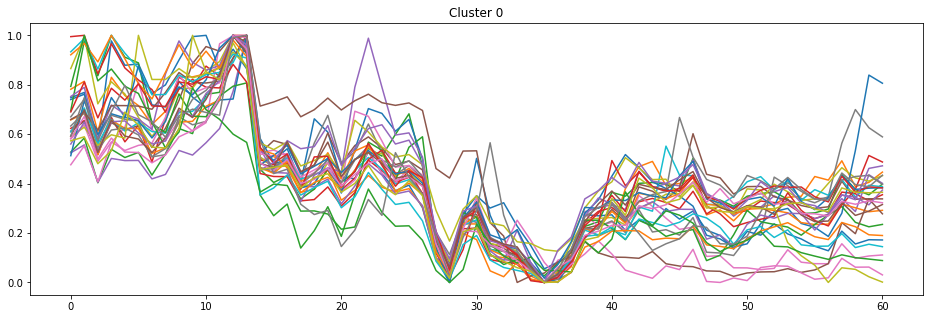

In [85]:
plt.figure(figsize=(16, 5))
pls =[]
for cluster in range(len(kmeans.labels_)):
    if kmeans.labels_[cluster] == 0:
        pls.append(list(days_scaled[days_scaled.columns[cluster]]))
for pl in pls:
    plt.plot(pl)
plt.title('Cluster 0')
plt.show()

In [117]:
def plot_average_clusters(clusters, data=days_scaled_T):
    #adjust number of plots. currently for 6 clusters
    fig, ax = plt.subplots(2, 3, figsize=(15, 8))
    ax = ax.reshape(-1)

    for i in range(n_clusters):
        averages = pd.DataFrame(data).groupby(clusters).mean().iloc[i].values
        stds = pd.DataFrame(data).groupby(clusters).std().iloc[i].values
        ax[i].plot(averages, color=colors[i])
        ax[i].fill_between(range(len(averages)),(averages - stds),(averages+stds),color = colors[i],alpha = .1)
        ax[i].set_title(f"Cluster {i}, {sum(clusters==i)} observations")
        #ax[i].legend(loc=1)
        ax[i].set_ylabel("Amplitude")
        ax[i].set_xlabel("observation")

    plt.tight_layout()
    plt.show()

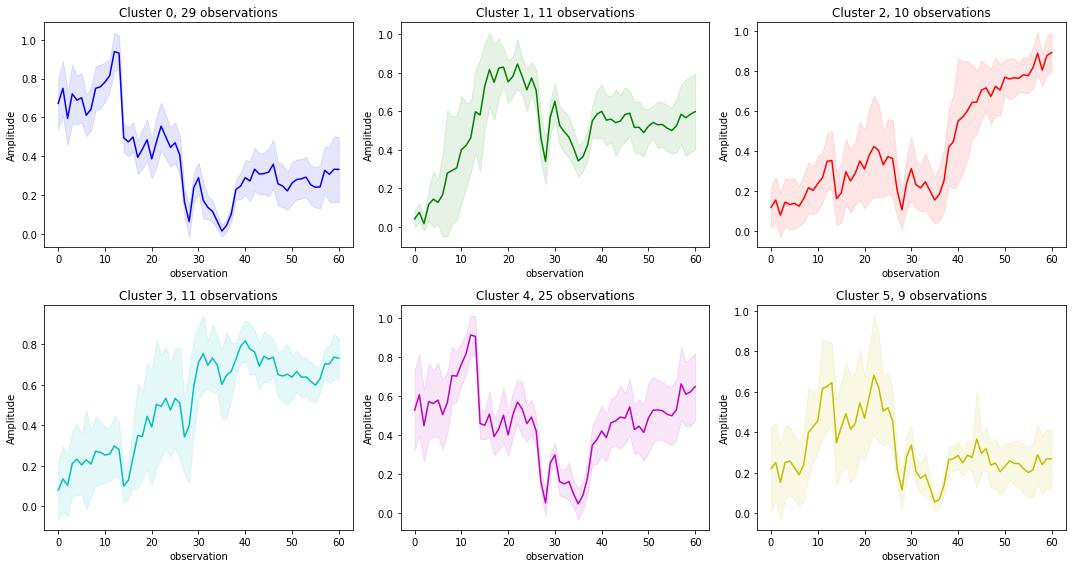

In [118]:
plot_average_clusters(kmeans.labels_)

# We can see that k-means clusterized 3 patterns:
- currencies which growing
- currencies which were growing and felt lower than in the beginning and now growing
- currencies which were growing, felt to the price like in the beginning and now growing rpidly again

# DTW clustering

In [141]:
from tslearn.clustering import TimeSeriesKMeans

ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters,  random_state=0,metric="softdtw", n_jobs=6, max_iter=10,dtw_inertia=True)
ts_kmeans.fit(days_scaled_T)
ts_kmeans.cluster_centers_.shape
dtw_clusters = ts_kmeans.predict(days_scaled_T)


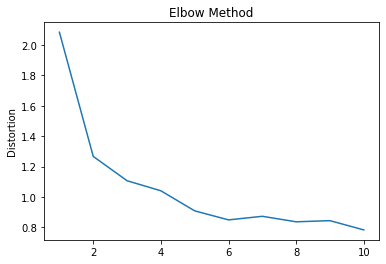

In [37]:
for n_clusters in candidates:
    ts_kmeans = TimeSeriesKMeans(n_clusters=n_clusters, metric="softdtw", n_jobs=6, max_iter=10, dtw_inertia=True)
    ts_kmeans.fit(days_scaled_T)
    #print(f'{n_clusters}{ts_kmeans.inertia_:.4f}')
    inertias.append(ts_kmeans.inertia_)
plt.plot(candidates,inertias)
plt.ylabel('Distortion')
plt.title('Elbow Method')
plt.show()

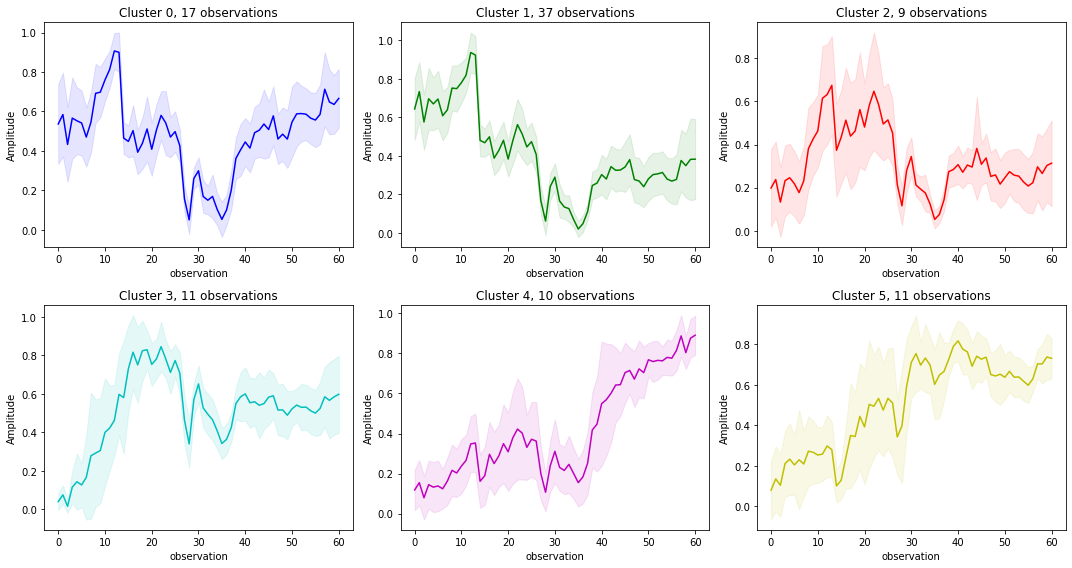

In [120]:
plot_average_clusters(dtw_clusters)

# With DTW clustering clasters similar to k-means but diving into 3 groups more even

- currencies which were growing and felt lower than in the beginning and now almost bounced back
- currencies which slowly going down in price
- currencies which growing


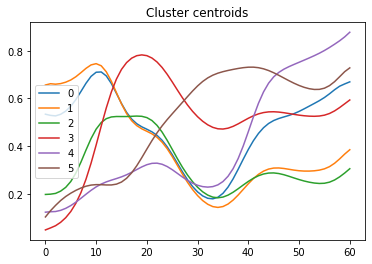

In [121]:
for cluster_number in range(n_clusters):
    plt.plot(ts_kmeans.cluster_centers_[cluster_number, :, 0].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

In [122]:
days_scaled_T['cluster'] = ts_kmeans.predict(days_scaled_T)

In [123]:
def plot_cluster_tickers(current_cluster):
    fig, ax = plt.subplots(
        int(np.ceil(current_cluster.shape[0]/4)),
        4,
        figsize=(15, 3*int(np.ceil(current_cluster.shape[0]/4)))
    )
    fig.autofmt_xdate(rotation=45)
    ax = ax.reshape(-1)

    for index, (_, row) in enumerate(current_cluster.iterrows()):
        ax[index].plot(row.iloc[5:-1])
        name = row.iloc[5:-1].name
        ax[index].set_title(f"{name}")
        plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

                          Cluster number: 0


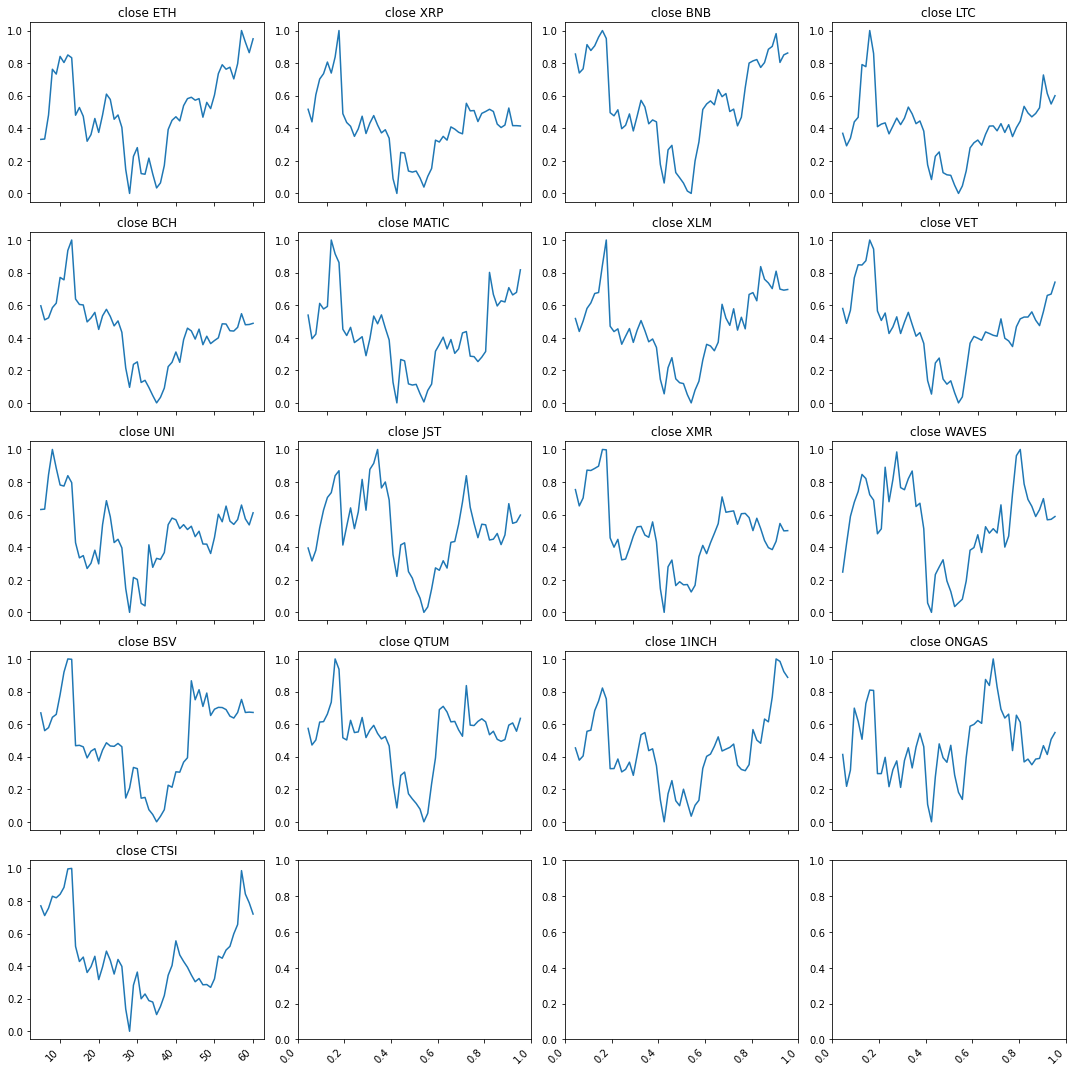

                          Cluster number: 1


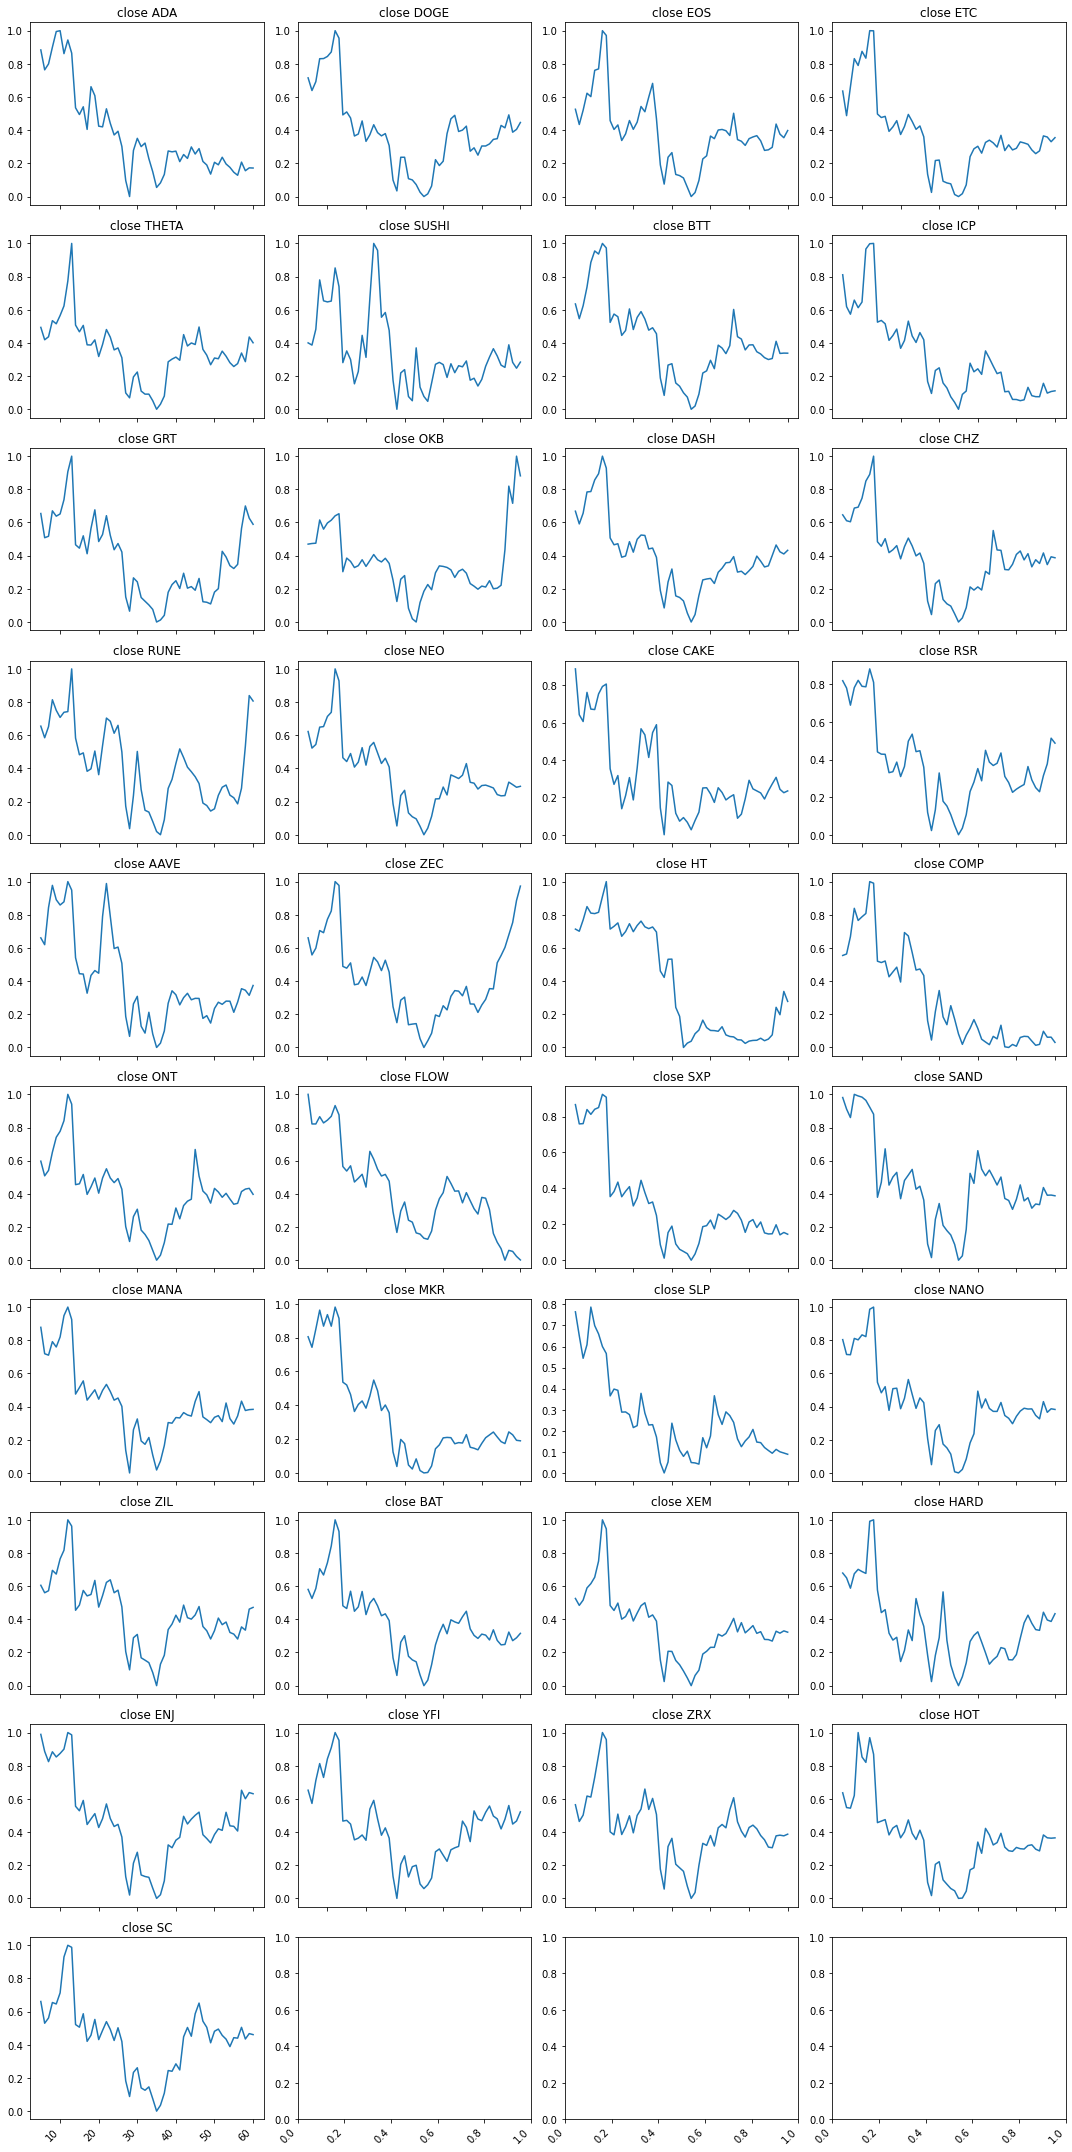

                          Cluster number: 2


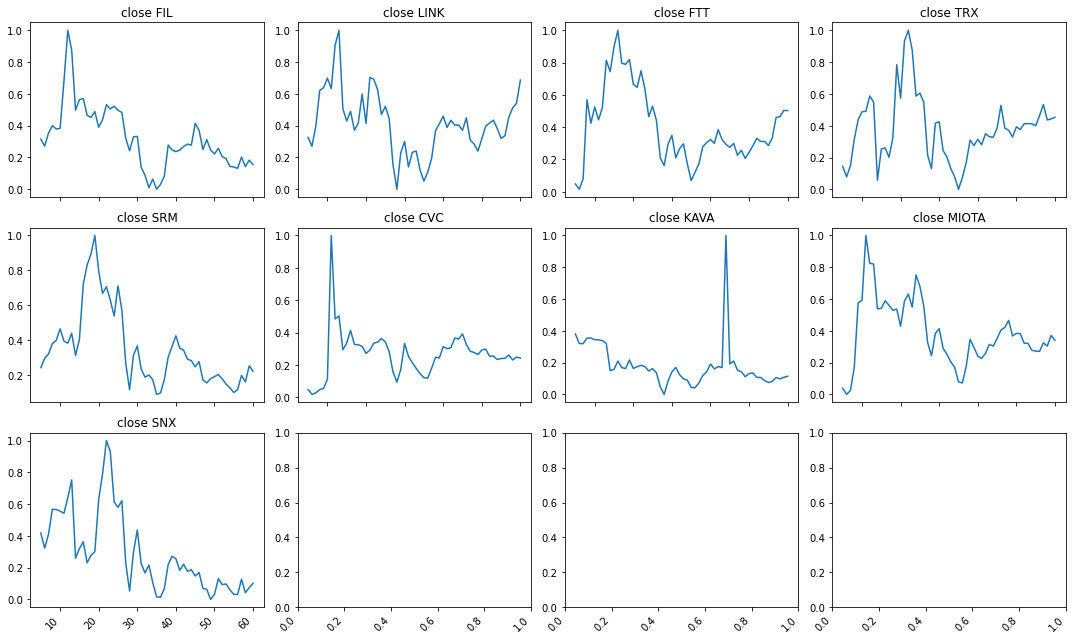

                          Cluster number: 3


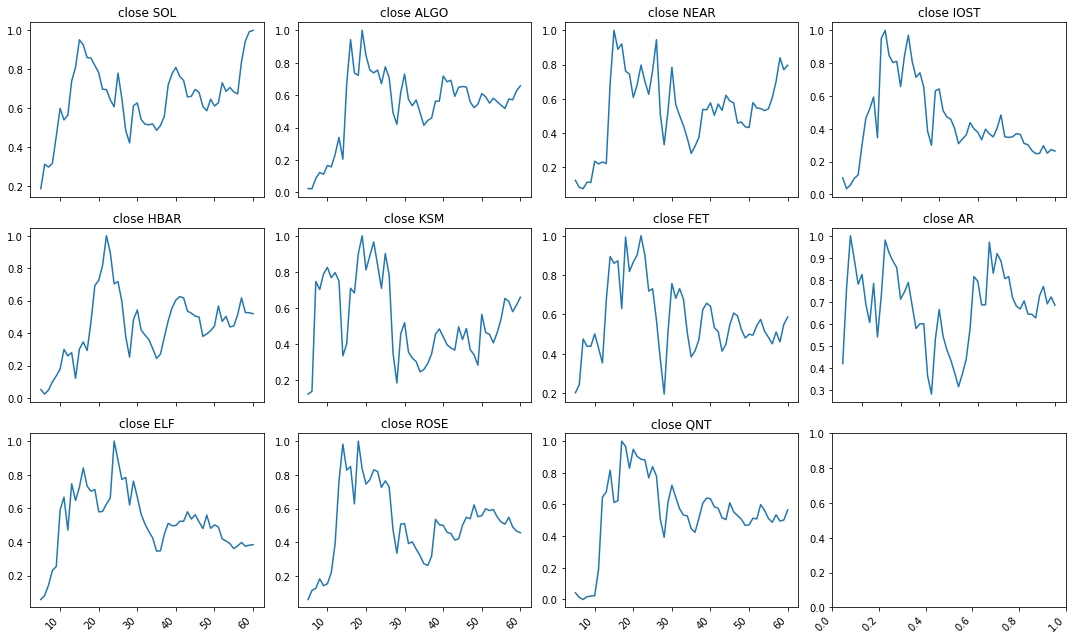

                          Cluster number: 4


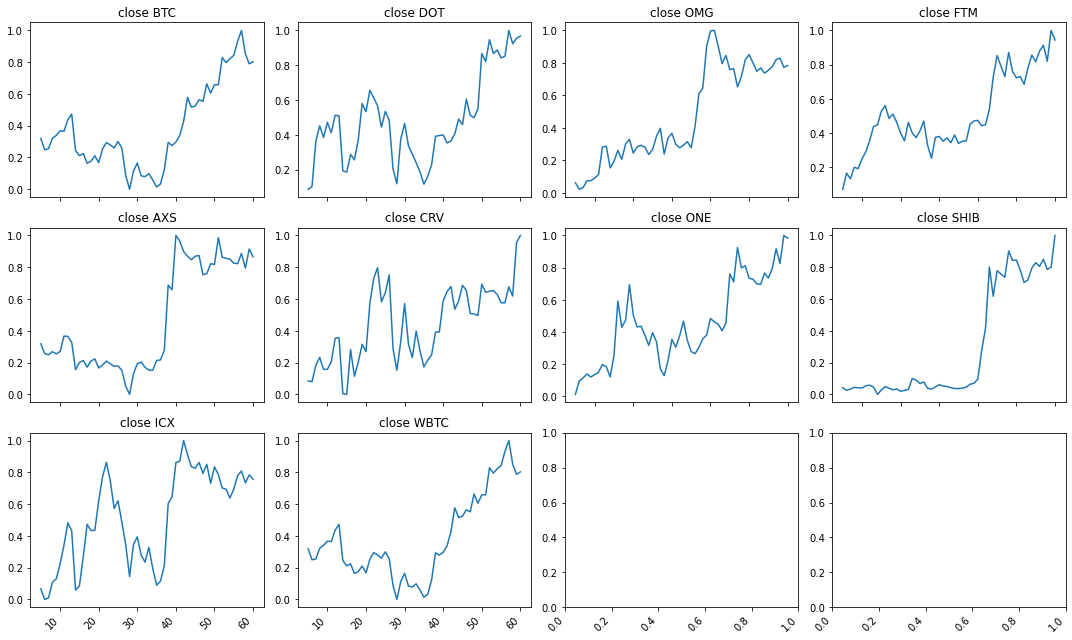

                          Cluster number: 5


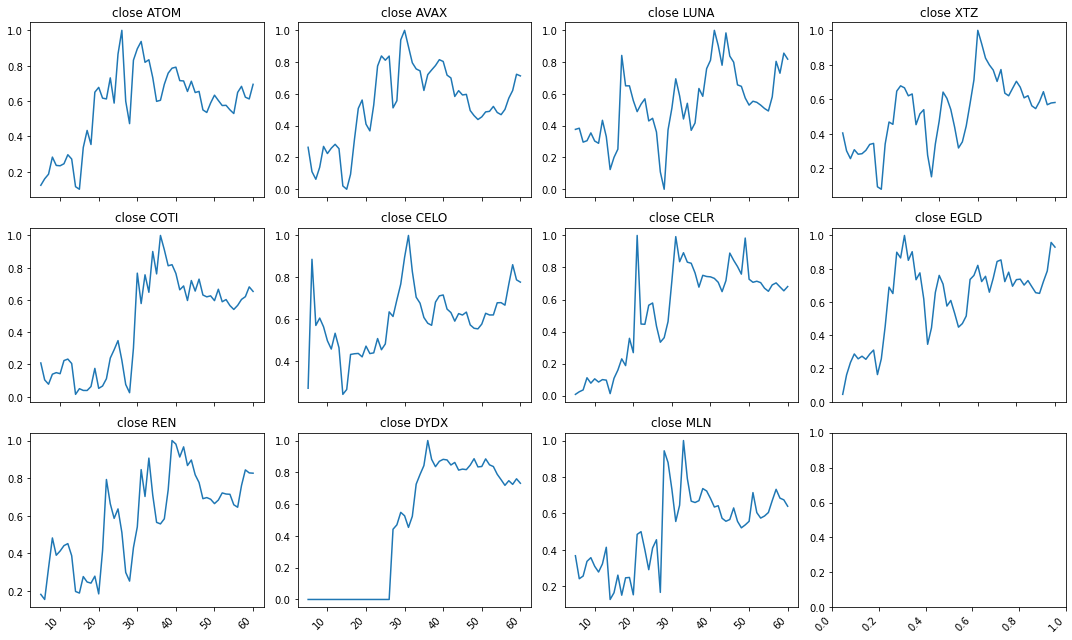

In [125]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(days_scaled_T[days_scaled_T.cluster==cluster])

# Feature clustering

In [126]:
from tsfresh import extract_features
days_scaled_T  = days_scaled_T.drop(columns = ['cluster'])
days_scaled_T.insert(0, 'id', range(0,len(days_scaled_T)))
extracted_features = extract_features(days_scaled_T, column_id='id')

Feature Extraction: 100%|██████████| 20/20 [00:25<00:00,  1.26s/it]


In [128]:
import tsfel
days_scaled_T2 = days_scaled_T.copy(deep=True)
corr_features = tsfel.correlated_features(days_scaled_T2)
days_scaled_T2.drop(corr_features, axis=1, inplace=True)

  0%|          | 0/9 [00:00<?, ?it/s]

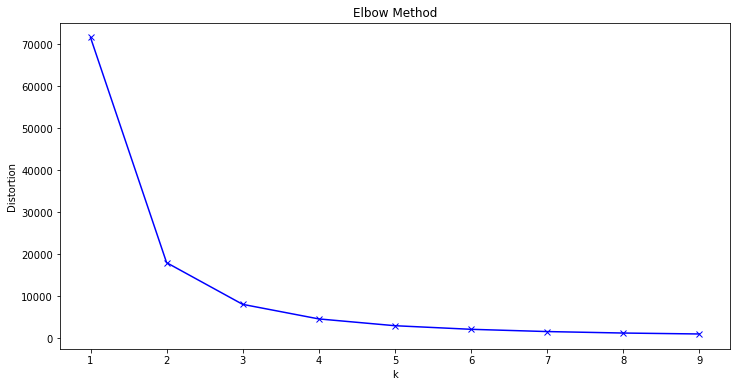

In [130]:
plot_distortions(range(1, 10), days_scaled_T2)

In [131]:
days_scaled_T2_scaled = scaler.fit_transform(days_scaled_T2)

In [142]:
kmeanModel_tsfel = KMeans(n_clusters=n_clusters, random_state = 0)
kmeanModel_tsfel.fit(days_scaled_T2_scaled)
clusters_tsfel = kmeanModel_tsfel.predict(days_scaled_T2_scaled)

KMeans(n_clusters=6, random_state=0)

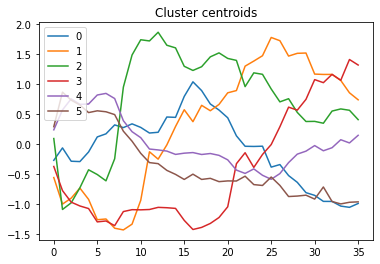

In [135]:
for cluster_number in range(n_clusters):
    plt.plot(kmeanModel_tsfel.cluster_centers_[cluster_number,:].T, label=cluster_number)
plt.title("Cluster centroids")
plt.legend()
plt.show()

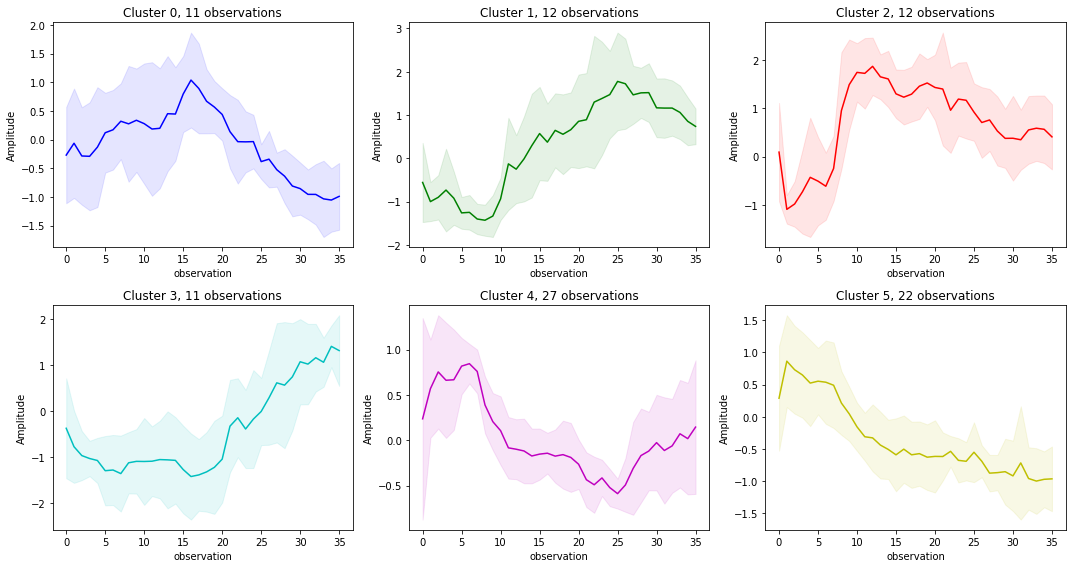

In [136]:
plot_average_clusters(clusters_tsfel, days_scaled_T2_scaled)

# Applying feature extraction method clasters similar to k-means in cluster size

- currencies which were growing and falling 
- currencies which were growing, felt and now growing back in price
- currencies which were falling, then long period of groth and now falling again



In [137]:
days_scaled_T2['cluster'] = clusters_tsfel

                          Cluster number: 0


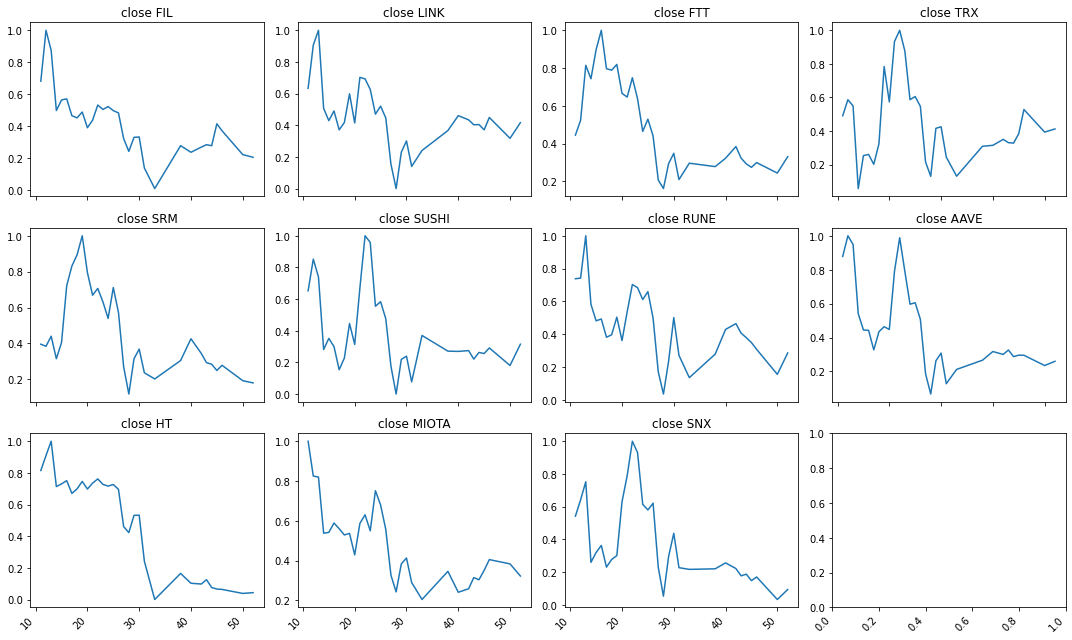

                          Cluster number: 1


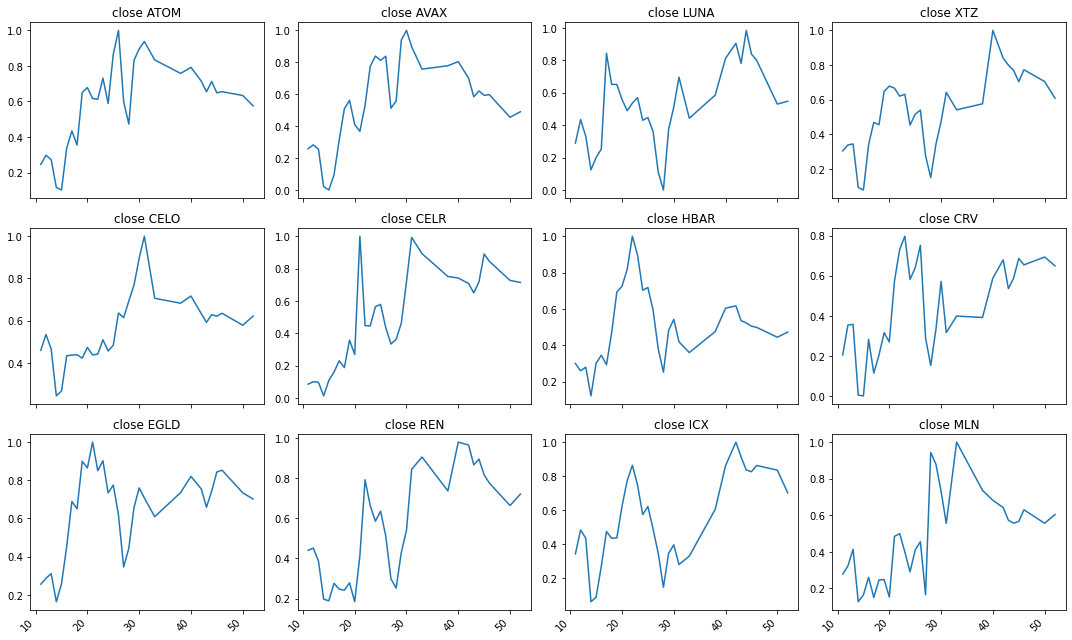

                          Cluster number: 2


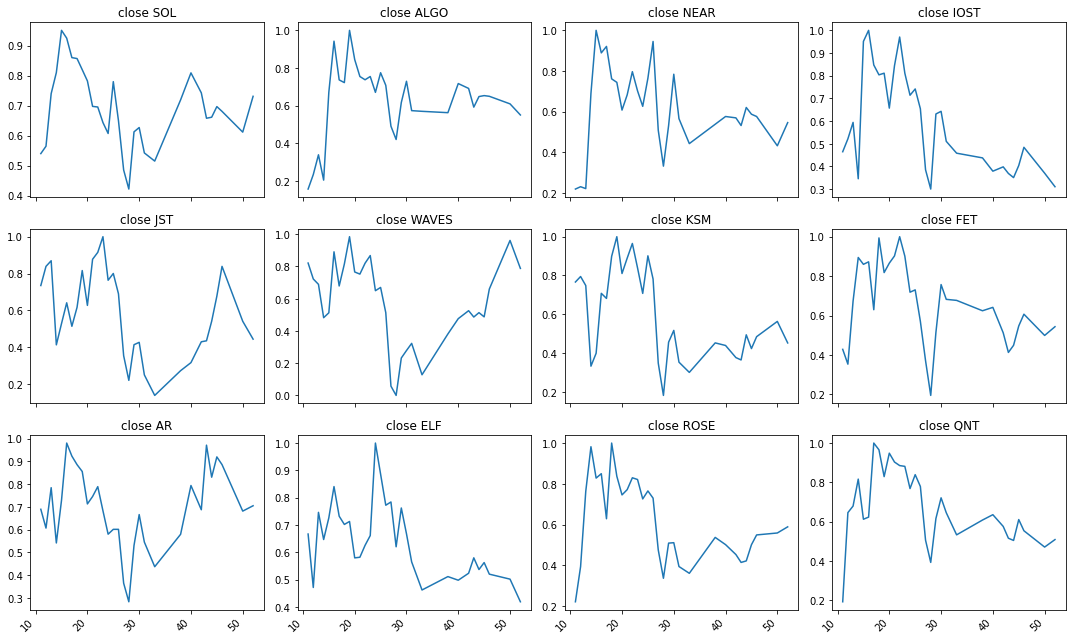

                          Cluster number: 3


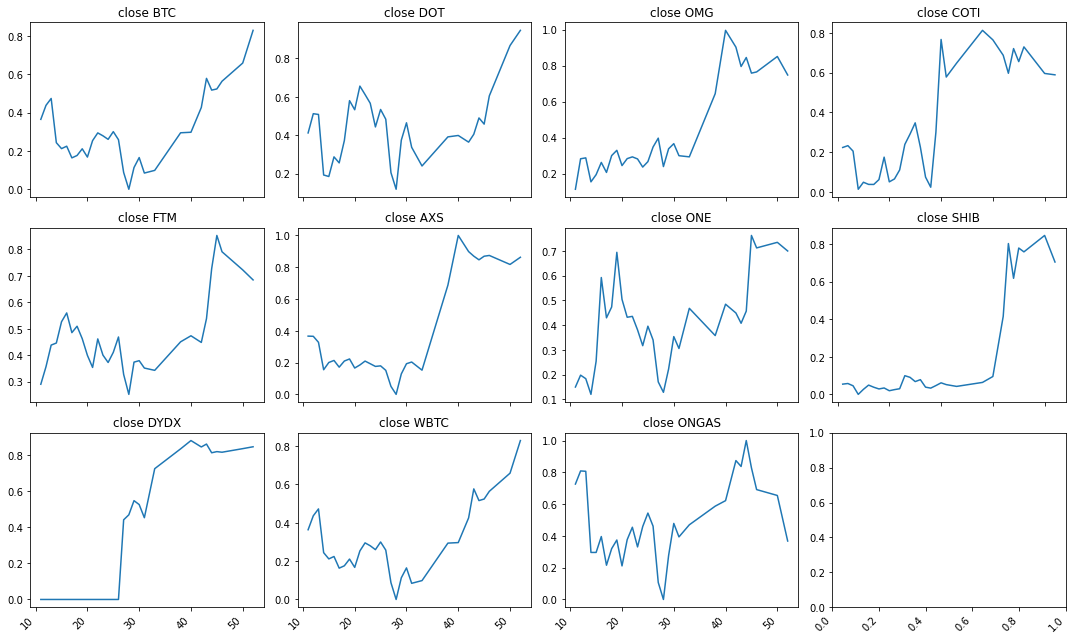

                          Cluster number: 4


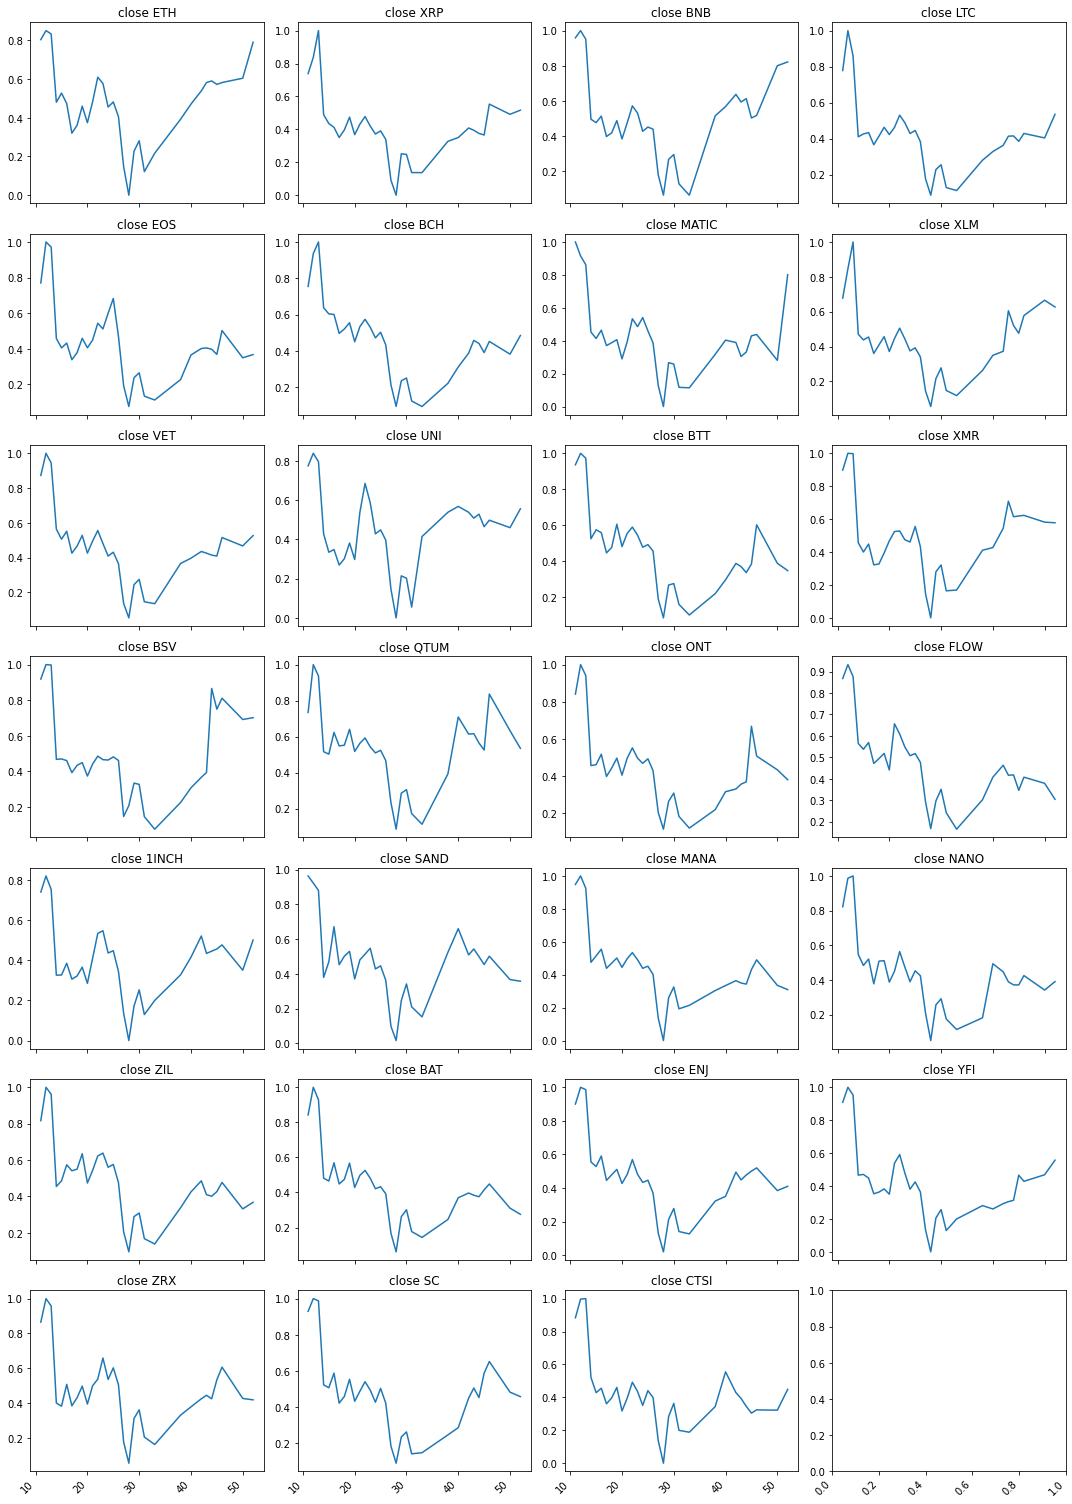

                          Cluster number: 5


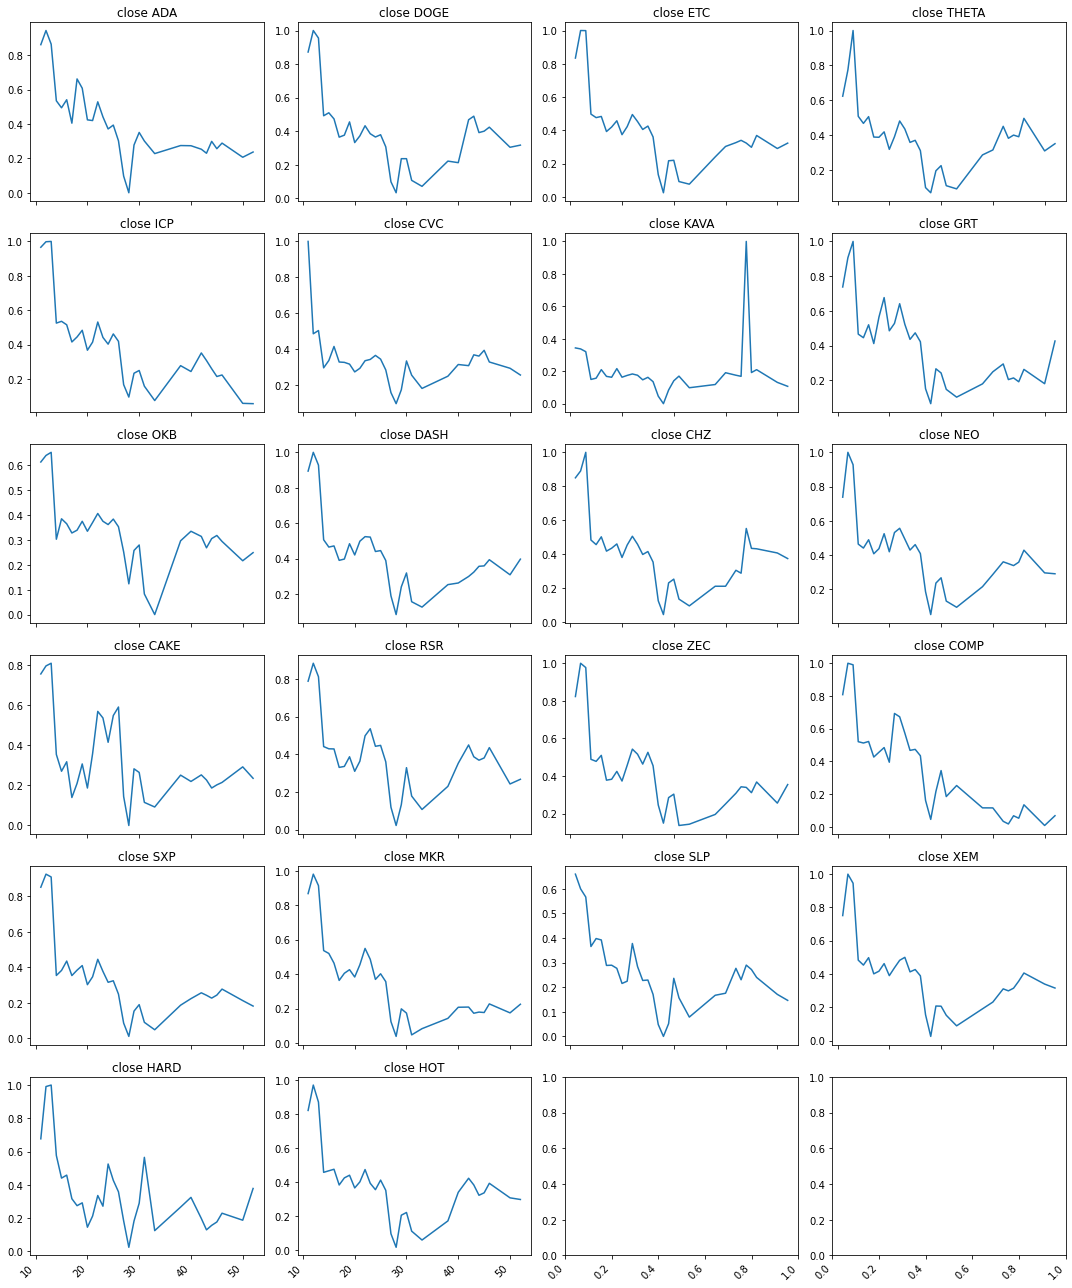

In [139]:
for cluster in range(n_clusters):
    print("=================================================================================")
    print(f"                          Cluster number: {cluster}")
    print("=================================================================================")
    plot_cluster_tickers(days_scaled_T2[days_scaled_T2.cluster==cluster])